# <영어 텍스트 분류> 
# - 영화 리뷰 감성 분석


- 데이터: kaggle competiton \<Bag of Words Meets Bags of Popcorn\>
    - IMDB(인터넷 영화 데이터베이스)의 영화 평점 데이터 활용

## 1. 데이터 분석 및 전처리
### 1.1. 데이터 불러오기

#### 1.1.1. 데이터 다운로드

In [ ]:
""" 0) kaggle 데이터 다운 (API 활용) """

!kaggle competitions download -c word2vec-nlp-tutorial

In [12]:
""" 1) 압축 풀기 """

import zipfile

zf = zipfile.ZipFile('./word2vec-nlp-tutorial.zip')
zf.extractall('./data_in/')
zf.close()

In [20]:
""" 2) 1차 압축해제 결과 확인
- zip 파일 내 zip 파일이 또 있었음 """

os.listdir('./data_in/')

['.ipynb_checkpoints',
 'labeledTrainData.tsv.zip',
 'sampleSubmission.csv',
 'testData.tsv.zip',
 'unlabeledTrainData.tsv.zip']

In [22]:
""" 3) zip 파일 내 zip 파일 압축해제 """

for i in os.listdir('./data_in'):
    if i.endswith('.zip'):
        zf = zipfile.ZipFile('./data_in/'+i)
        zf.extractall('./data_in/')
        zf.close()
        os.remove('./data_in/'+i)

#### 1.1.2. 라이브러리 import 및 데이터 구조 확인

In [23]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [29]:
train_data = pd.read_csv('./data_in/labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
# delimiter = sep
# quoting=3 : 쌍따옴표 무시
# 어떤 값에 대해서 인용구를 설정
# {0 : MINIMAL 문자와 특수문자 / 1 : ALL 모든필드 / 2 : NONNUMERIC 숫자가 아닌것 / 3 : NONE 안함}
train_data.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [26]:
""" quoting 값 바꿨을 경우 """

train_data = pd.read_csv('./data_in/labeledTrainData.tsv', header=None, sep='\t', quoting=1)
train_data.head()

,0,1,2
0,id,sentiment,review
1,5814_8,1,With all this stuff going down at the moment w...
2,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
3,7759_3,0,The film starts with a manager (Nicholas Bell)...
4,3630_4,0,It must be assumed that those who praised this...


### 1.2. 데이터 분석
#### 1.2.1. 데이터 크기 확인

In [30]:
print("파일 크기 : ")

for file in os.listdir('./data_in'):
    if 'tsv' in file and 'zip' not in file:
        print(file.ljust(30) + str(round(os.path.getsize('./data_in/' + file)/1000000, 2)) + 'MB')
        
# file.ljust(30) : 'unlabeledTrainData.tsv        '
# os.path : <module 'ntpath' from 'C:\\Users\\answl\\anaconda3\\envs\\nlp\\lib\\ntpath.py'>
# os.path.getsize(__) : 33556378

파일 크기 : 
labeledTrainData.tsv          33.56MB
testData.tsv                  32.72MB
unlabeledTrainData.tsv        67.28MB


#### 1.2.2. 데이터 개수 확인

In [45]:
""" 전체 학습 데이터 개수 """

len(train_data)

25000

#### 1.2.3. 각 리뷰의 문자 길이 분포 확인

In [46]:
train_length = train_data['review'].apply(len)
train_length.head()

0    2304
1     948
2    2451
3    2247
4    2233
Name: review, dtype: int64

Text(0, 0.5, 'Number of review')

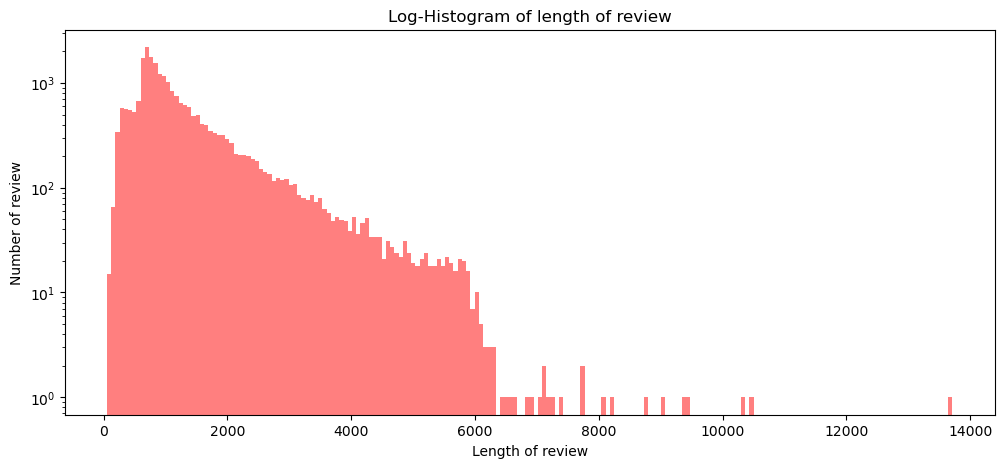

In [55]:
""" 각 리뷰 길이 히스토그램 만들기 """

# 1) 그래프에 대한 이미지 크기 선언
plt.figure(figsize=(12,5))

# 2) 히스토그램 선언
plt.hist(train_length, bins=200, alpha=0.5, color='r', label='word')
# bins: 히스토그램 값에 대한 버킷 범위
# alpha: 그래프 색상 투명도
plt.yscale('log', nonpositive='clip')
# y값이 log의 크기를 갖도록 설정

# 3) 그래프 제목
plt.title('Log-Histogram of length of review')

# 4) 그래프 x축 라벨
plt.xlabel('Length of review')

# 5) 그래프 y축 라벨
plt.ylabel('Number of review')

In [57]:
print("리뷰 길이 최대값: {}".format(np.max(train_length)))
print("리뷰 길이 최소값: {}".format(np.min(train_length)))
print("리뷰 길이 평균값: {:.2f}".format(np.mean(train_length)))
print("리뷰 길이 표준편차: {:.2f}".format(np.std(train_length)))
print("리뷰 길이 중간값: {}".format(np.median(train_length)))

# 사분위에 대한 경우는 0~100 스케일로 되어 있음
print("리뷰 길이 제1사분위: {}".format(np.percentile(train_length, 25)))
print("리뷰 길이 제3사분위: {}".format(np.percentile(train_length, 75)))

리뷰 길이 최대값: 13710
리뷰 길이 최소값: 54
리뷰 길이 평균값: 1329.71
리뷰 길이 표준편차: 1005.22
리뷰 길이 중간값: 983.0
리뷰 길이 제1사분위: 705.0
리뷰 길이 제3사분위: 1619.0


{'whiskers': [<matplotlib.lines.Line2D at 0x21f5e34b048>,
 'caps': [<matplotlib.lines.Line2D at 0x21f5e32d3c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x21f5e310f48>],
 'medians': [<matplotlib.lines.Line2D at 0x21f5e325f88>],
 'fliers': [<matplotlib.lines.Line2D at 0x21f5e32d188>],
 'means': [<matplotlib.lines.Line2D at 0x21f5e32d1c8>]}

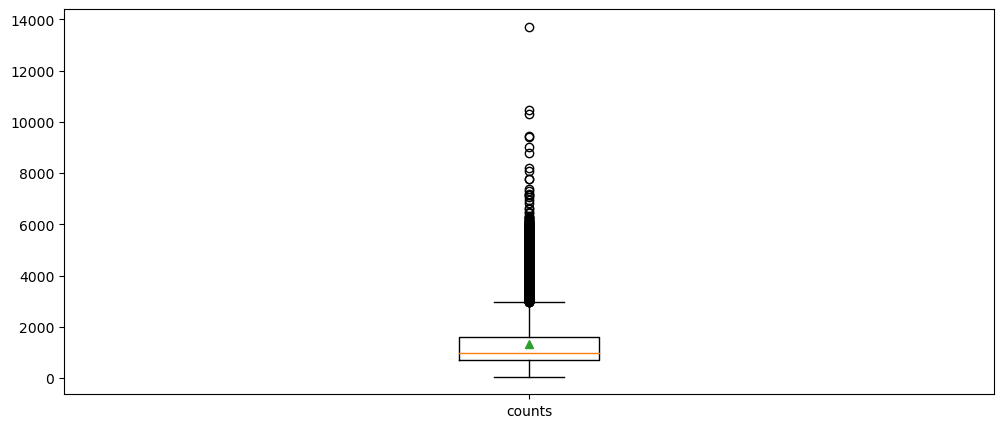

In [59]:
plt.figure(figsize=(12,5))

plt.boxplot(train_length,
           labels=['counts'],
           showmeans=True)

#### 1.2.4. 리뷰에서 많이 사용된 단어 확인

(-0.5, 799.5, 599.5, -0.5)

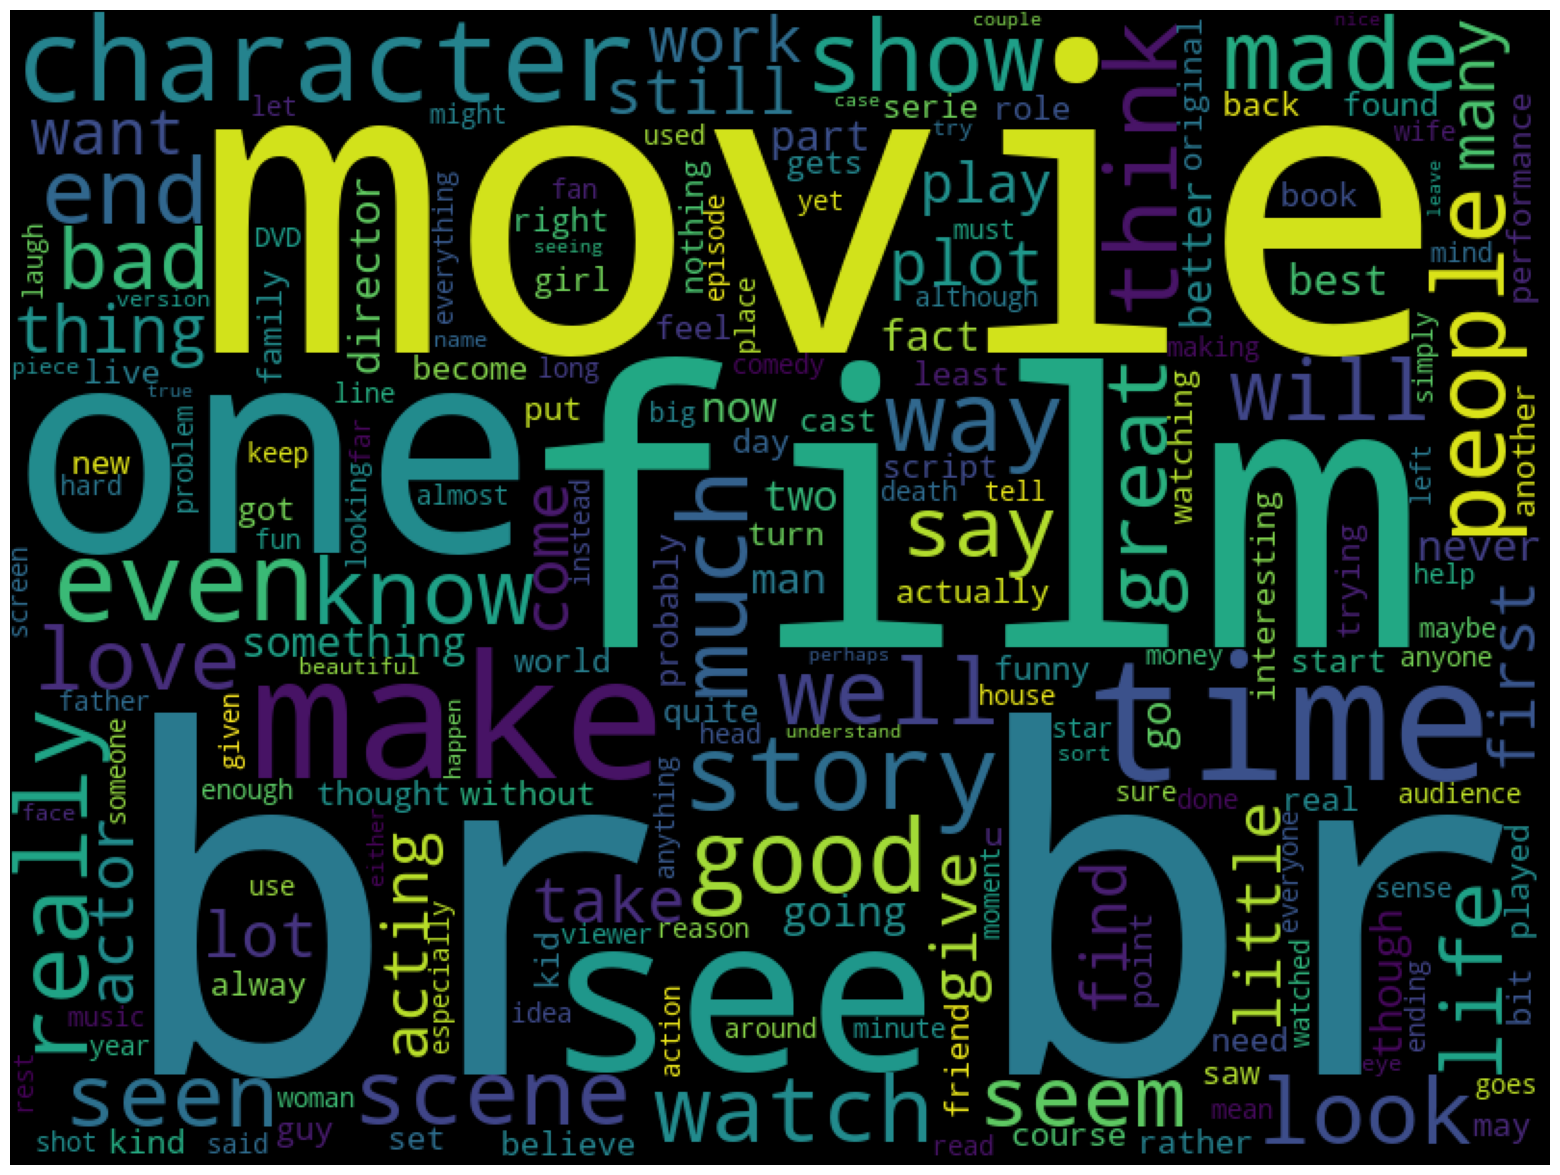

In [62]:
from wordcloud import WordCloud

cloud = WordCloud(width=800, height=600).generate(" ".join(train_data['review']))

plt.figure(figsize=(20,15))
plt.imshow(cloud)
plt.axis('off')

br: HTML 태그 중 하나 --> 정제되지 않은 인터넷 상의 리뷰 형태로 되어있는 데이터임을 알 수 있다.

--> 전처리 작업에서 이를 제거

#### 1.2.5. 각 라벨의 분포 확인 

C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

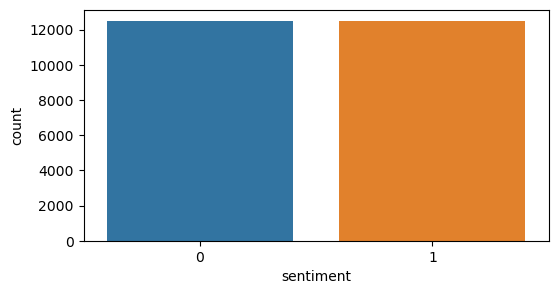

In [67]:
fig, ax = plt.subplots(ncols=1)
# fig: <Figure size 640x480 with 1 Axes>
# ax: <AxesSubplot:>
fig.set_size_inches(6,3)
sns.countplot(train_data['sentiment'])
# ax: <AxesSubplot:xlabel='sentiment', ylabel='count'>

In [75]:
print("긍정 리뷰 개수: {}".format(train_data['sentiment'].value_counts()[1]))
print("부정 리뷰 개수: {}".format(train_data['sentiment'].value_counts()[0]))

긍정 리뷰 개수: 12500
부정 리뷰 개수: 12500


In [76]:
train_data['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

#### 1.2.6. 각 리뷰의 단어 개수 확인 

Text(0, 0.5, 'Number of reviews')

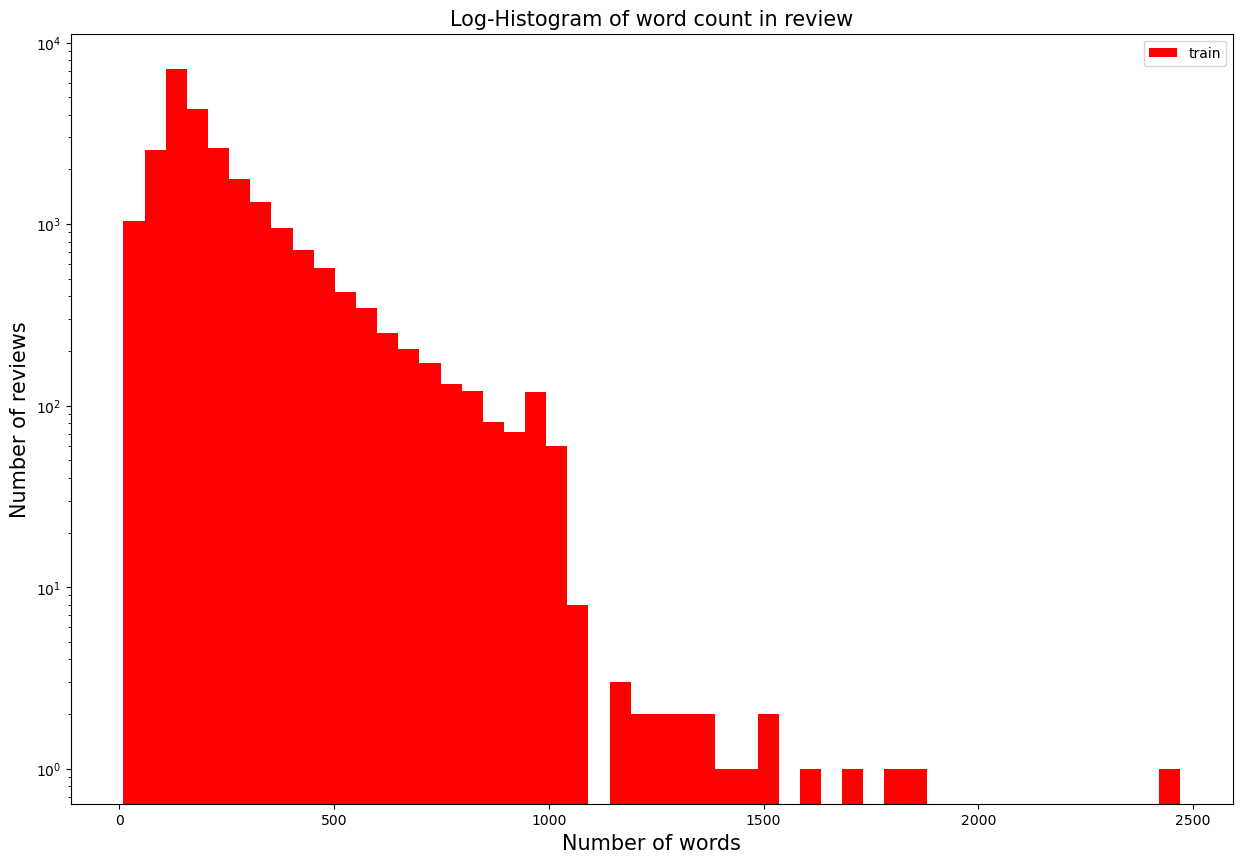

In [77]:
train_word_counts = train_data['review'].apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15,10))

plt.hist(train_word_counts, bins=50, facecolor='r', label='train')
# facecolor = color

plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonpositive='clip')

plt.legend() # 그래프에 범례(label) 추가 

plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)

In [79]:
print("리뷰 단어 개수 최대값: {}".format(np.max(train_word_counts)))
print("리뷰 단어 개수 최소값: {}".format(np.min(train_word_counts)))
print("리뷰 단어 개수 평균값: {}".format(np.mean(train_word_counts)))
print("리뷰 단어 개수 중앙값: {}".format(np.median(train_word_counts)))
print("리뷰 단어 개수 표준편차: {}".format(np.std(train_word_counts)))

print("리뷰 단어 개수 제1사분위: {}".format(np.percentile(train_word_counts, 25)))
print("리뷰 단어 개수 제3사분위: {}".format(np.percentile(train_word_counts, 75)))

리뷰 단어 개수 최대값: 2470
리뷰 단어 개수 최소값: 10
리뷰 단어 개수 평균값: 233.78624
리뷰 단어 개수 중앙값: 174.0
리뷰 단어 개수 표준편차: 173.74237015380743
리뷰 단어 개수 제1사분위: 127.0
리뷰 단어 개수 제3사분위: 284.0


#### 1.2.7. 각 리뷰의 특수문자 및 대문자, 소문자 비율 확인

In [80]:
qmarks = np.mean(train_data['review'].apply(lambda x: '?' in x)) # 물음표 있는 문장 평균
fullstop = np.mean(train_data['review'].apply(lambda x: '.' in x)) # '.'이 있는 문장 
capital_first = np.mean(train_data['review'].apply(lambda x: x[0].isupper())) # 문장 첫알파벳이 대문자
capitals = np.mean(train_data['review'].apply(lambda x: max([y.isupper() for y in x])))
# 각 문장의 모든 알파벳 중 대문자가 하나라도 있으면 True 반환
numbers = np.mean(train_data['review'].apply(lambda x: max([y.isdigit() for y in x])))

print("물음표가 있는 질문: {:.2f}%".format(qmarks * 100))
print("마침표가 있는 질문: {:.2f}%".format(fullstop * 100))
print("첫 글자가 대문자인 질문: {:.2f}%".format(capital_first * 100))
print("대문자가 있는 질문: {:.2f}%".format(capitals * 100))
print("숫자가 있는 질문: {:.2f}%".format(numbers * 100))

물음표가 있는 질문: 29.55%
마침표가 있는 질문: 99.69%
첫 글자가 대문자인 질문: 0.00%
대문자가 있는 질문: 99.59%
숫자가 있는 질문: 56.66%


In [81]:
train_data['review'].apply(lambda x: '?' in x)

0         True
1        False
2        False
3         True
4         True
         ...  
24995    False
24996    False
24997    False
24998     True
24999    False
Name: review, Length: 25000, dtype: bool

In [82]:
np.mean(train_data['review'].apply(lambda x: '?' in x))

0.29552

대부분 마침표 포함, 대문자 사용

--> 모두 소문자로 바꾸고, 특수문자 제거
- 학습에 방해되는 요소 제거

### 1.3. 데이터 전처리

In [19]:
import pandas as pd
import json

# 데이터 정제
from bs4 import BeautifulSoup # HTML 태그 제거
import re # re.sub --> 특수문자 제거

from nltk.corpus import stopwords # 불용어 제거

# 텐서플로의 전처리 모듈
from tensorflow.keras.preprocessing.sequence \
     import pad_sequences
from tensorflow.keras.preprocessing.text \
     import Tokenizer

import numpy as np # 전처리된 데이터 저장

In [2]:
DATA_IN_PATH = "./data_in/"

train_data = pd.read_csv(DATA_IN_PATH + 'labeledTrainData.tsv',
                        header=0, sep='\t', quoting=3)
print(train_data['review'][0])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [3]:
review = train_data['review'][0]

# HTML 태그 제거 
review_text = BeautifulSoup(review, "html5lib").get_text()
review_text = re.sub("[^A-Za-z]", " ", review_text)

In [4]:
print(review_text)

 With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    mi

In [5]:
BeautifulSoup(review, "html5lib")

<html><head></head><body>"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br/><br/>Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br/><br/>The actual feature film bi

In [9]:
BeautifulSoup(review, "html5lib").get_text()

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts is only on for 2

In [6]:
# 총 179개 nltk.corpus.stopwords.words의 영어 불용어!
stop_words = set(stopwords.words('english'))

review_text = review_text.lower()
words = review_text.split()
words = [w for w in words if w not in stop_words]

print(words)

['stuff', 'going', 'moment', 'mj', 'started', 'listening', 'music', 'watching', 'odd', 'documentary', 'watched', 'wiz', 'watched', 'moonwalker', 'maybe', 'want', 'get', 'certain', 'insight', 'guy', 'thought', 'really', 'cool', 'eighties', 'maybe', 'make', 'mind', 'whether', 'guilty', 'innocent', 'moonwalker', 'part', 'biography', 'part', 'feature', 'film', 'remember', 'going', 'see', 'cinema', 'originally', 'released', 'subtle', 'messages', 'mj', 'feeling', 'towards', 'press', 'also', 'obvious', 'message', 'drugs', 'bad', 'kay', 'visually', 'impressive', 'course', 'michael', 'jackson', 'unless', 'remotely', 'like', 'mj', 'anyway', 'going', 'hate', 'find', 'boring', 'may', 'call', 'mj', 'egotist', 'consenting', 'making', 'movie', 'mj', 'fans', 'would', 'say', 'made', 'fans', 'true', 'really', 'nice', 'actual', 'feature', 'film', 'bit', 'finally', 'starts', 'minutes', 'excluding', 'smooth', 'criminal', 'sequence', 'joe', 'pesci', 'convincing', 'psychopathic', 'powerful', 'drug', 'lord', 

In [37]:
print(stop_words)

{'few', "don't", 's', 'this', 'myself', 'didn', 'himself', "mightn't", 'not', "it's", 'again', 'over', 'in', 'them', 'o', "wasn't", 'by', 'are', 'me', 'i', 'should', 'haven', 'so', 'at', 'out', 'of', 'on', 'yours', 'did', "isn't", "couldn't", 'having', 'will', 'do', 'yourselves', 'their', 'it', 'now', 'most', 'couldn', 'theirs', 'ourselves', 'can', "you've", 'weren', 'below', 'he', 'such', "hadn't", 'against', 'have', 'been', "you'd", 'hasn', 'my', 'for', "haven't", 'up', 'don', 'an', 'when', "that'll", 'each', 'just', 'if', 'other', 'his', 'mightn', 'more', "wouldn't", 'while', 'the', 'nor', 'does', 'very', 'shan', 'herself', 'until', 'am', 'she', 'doesn', 'some', 'own', 'doing', 'hadn', 'her', 'because', 'after', 'him', "you're", 'ours', 'which', 'off', 'is', 'yourself', 'its', 'being', 'they', 'once', 'why', 'than', 'isn', 'who', "mustn't", 'too', 'with', 'no', 'to', "shouldn't", 'your', 'between', 'themselves', "hasn't", 'd', "you'll", 'only', 'mustn', 'there', "needn't", 'aren', '

In [38]:
len(stop_words)

179

In [7]:
clean_review = ' '.join(words)
print(clean_review)

stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate working

In [8]:
def preprocessing(review, remove_stopwords=False):
    # 불용어 제거는 옵션으로 선택 가능
    
    # 1. HTML 태그 제거
    review_text = BeautifulSoup(review, "html5lib").get_text()
    
    # 2. 영어 아닌 특수문자들 공백으로 바꾸기
    review_text = re.sub("[^A-Za-z]", " ", review_text)
    
    # 3. 대문자들을 소문자로 바꾸고 공백단위로 텍스트 나누기
    words = review_text.lower().split()
    
    if remove_stopwords:
        # 4. 불용어 제거
        
        stops = set(stopwords.words("english"))
        words = [w for w in words if w not in stops]
        
        # 5. 하나의 글로 다시 합치기
        clean_review = ' '.join(words)
    
    else:
        clean_review = ' '.join(words)
        
    return clean_review

In [9]:
clean_train_reviews = []

for review in train_data['review']:
    clean_train_reviews.append(preprocessing(review, True))
    
# 전처리한 데이터 출력
clean_train_reviews[0]

C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\bs4\__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate workin

In [10]:
clean_train_df = pd.DataFrame({'review':clean_train_reviews,
                              'sentiment':train_data['sentiment']})

In [12]:
clean_train_df

,review,sentiment
0,stuff going moment mj started listening music ...,1
1,classic war worlds timothy hines entertaining ...,1
2,film starts manager nicholas bell giving welco...,0
3,must assumed praised film greatest filmed oper...,0
4,superbly trashy wondrously unpretentious explo...,1
...,...,...
24995,seems like consideration gone imdb reviews fil...,0
24996,believe made film completely unnecessary first...,0
24997,guy loser get girls needs build picked stronge...,0
24998,minute documentary bu uel made early one spain...,0


In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_reviews)
text_sequences = tokenizer.texts_to_sequences(clean_train_reviews)

print(text_sequences[0])

[404, 70, 419, 8815, 506, 2456, 115, 54, 873, 516, 178, 18686, 178, 11242, 165, 78, 14, 662, 2457, 117, 92, 10, 499, 4074, 165, 22, 210, 581, 2333, 1194, 11242, 71, 4826, 71, 635, 2, 253, 70, 11, 302, 1663, 486, 1144, 3265, 8815, 411, 793, 3342, 17, 441, 600, 1500, 15, 4424, 1851, 998, 146, 342, 1442, 743, 2424, 4, 8815, 418, 70, 637, 69, 237, 94, 541, 8815, 26055, 26056, 120, 1, 8815, 323, 8, 47, 20, 323, 167, 10, 207, 633, 635, 2, 116, 291, 382, 121, 15535, 3315, 1501, 574, 734, 10013, 923, 11578, 822, 1239, 1408, 360, 8815, 221, 15, 576, 8815, 22224, 2274, 13426, 734, 10013, 27, 28606, 340, 16, 41, 18687, 1500, 388, 11243, 165, 3962, 8815, 115, 627, 499, 79, 4, 8815, 1430, 380, 2163, 114, 1919, 2503, 574, 17, 60, 100, 4875, 5100, 260, 1268, 26057, 15, 574, 493, 744, 637, 631, 3, 394, 164, 446, 114, 615, 3266, 1160, 684, 48, 1175, 224, 1, 16, 4, 8815, 3, 507, 62, 25, 16, 640, 133, 231, 95, 7426, 600, 3439, 8815, 37248, 1864, 1, 128, 342, 1442, 247, 3, 865, 16, 42, 1487, 997, 2333, 12

In [14]:
word_vocab = tokenizer.word_index
word_vocab["<PAD>"] = 0

print("전체 단어 개수: ", len(word_vocab))

word_vocab

전체 단어 개수:  74066


{'movie': 1,
 'film': 2,
 'one': 3,
 'like': 4,
 'good': 5,
 'time': 6,
 'even': 7,
 'would': 8,
 'story': 9,
 'really': 10,
 'see': 11,
 'well': 12,
 'much': 13,
 'get': 14,
 'bad': 15,
 'people': 16,
 'also': 17,
 'first': 18,
 'great': 19,
 'made': 20,
 'way': 21,
 'make': 22,
 'could': 23,
 'movies': 24,
 'think': 25,
 'characters': 26,
 'character': 27,
 'watch': 28,
 'two': 29,
 'films': 30,
 'seen': 31,
 'many': 32,
 'life': 33,
 'plot': 34,
 'acting': 35,
 'never': 36,
 'love': 37,
 'little': 38,
 'best': 39,
 'show': 40,
 'know': 41,
 'ever': 42,
 'man': 43,
 'better': 44,
 'end': 45,
 'still': 46,
 'say': 47,
 'scene': 48,
 'scenes': 49,
 'go': 50,
 'something': 51,
 'back': 52,
 'real': 53,
 'watching': 54,
 'though': 55,
 'thing': 56,
 'old': 57,
 'years': 58,
 'actors': 59,
 'director': 60,
 'work': 61,
 'another': 62,
 'new': 63,
 'nothing': 64,
 'funny': 65,
 'actually': 66,
 'makes': 67,
 'look': 68,
 'find': 69,
 'going': 70,
 'part': 71,
 'lot': 72,
 'every': 73,
 'wo

In [15]:
data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

In [16]:
MAX_SEQUENCE_LENGTH = 174

train_inputs = pad_sequences(
    text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print("Shape of train data: ", train_inputs.shape)

Shape of train data:  (25000, 174)


In [20]:
train_labels = np.array(train_data['sentiment'])
print("Shape of label tensor: ", train_labels.shape)

Shape of label tensor:  (25000,)


In [21]:
TRAIN_INPUT_DATA = "train_input.npy"
TRAIN_LABEL_DATA = "train_label.npy"
TRAIN_CLEAN_DATA = "train_clean.csv"
DATA_CONFIGS = "data_configs.json"

import os

if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)

In [27]:
# 전처리된 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)

# 정제된 텍스트를 csv 형태로 저장
clean_train_df.to_csv(DATA_IN_PATH + TRAIN_CLEAN_DATA, index=False)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, 
          open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)

In [28]:
# 테스트 셋에도 똑같이 전처리 과정 적용

test_data = pd.read_csv(
    DATA_IN_PATH + 'testData.tsv', header=0, sep='\t', quoting=3)

clean_test_reviews = []

for review in test_data['review']:
    clean_test_reviews.append(preprocessing(review, remove_stopwords = True))
    
clean_test_df = pd.DataFrame({'review':clean_test_reviews,
                             'id':test_data['id']})
test_id = np.array(test_data['id'])

text_sequences = tokenizer.texts_to_sequences(clean_test_reviews)
test_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

TEST_INPUT_DATA = 'test_input.npy'
TEST_CLEAN_DATA = 'test_clean.csv'
TEST_ID_DATA = 'test_id.npy'

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_ID_DATA, 'wb'), test_id)
clean_test_df.to_csv(DATA_IN_PATH+TEST_CLEAN_DATA, index=False)

C:\Users\answl\anaconda3\envs\nlp\lib\site-packages\bs4\__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [34]:
np.load(DATA_IN_PATH + TRAIN_INPUT_DATA)

array([[  411,   793,  3342, ..., 18689,   316,  1356],
       [  232,   203,  3048, ...,     0,     0,     0],
       [ 1416,  2366,  1362, ...,   700,  1175,  5310],
       ...,
       [  117,  3104,    14, ...,     0,     0,     0],
       [  639,   516, 16593, ...,     0,     0,     0],
       [  109,     1,   350, ...,     0,     0,     0]])

In [35]:
np.load(DATA_IN_PATH + TRAIN_LABEL_DATA)

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)